# Revolut Financial Crime Challenge
## Home Task

# TASK 1.a - Communication and SQL familiarity

#### Examine the following SQL query, and explain clearly and succinctly what it means. Will the query work? Explain why or why not. (15 points)

```SQL
WITH processed_users AS (
SELECT left(u.phone_country, 2) AS short_phone_country, u.id 
FROM users u
)
SELECT t.user_id, 
t.merchant_country, 
sum(t.amount / fx.rate / power(10, cd.exponent)) AS amount 
FROM transactions t
JOIN fx_rates fx ON (fx.ccy = t.currency AND fx.base_ccy = 'EUR')
JOIN currency_details cd ON cd.currency = t.currency
JOIN processed_users pu ON pu.id = t.user_id
WHERE t.source = 'GAIA'
AND pu.short_phone_country = t.merchant_country
GROUP BY t.user_id, t.merchant_country

ORDER BY amount DESC;```

<img src="Screenshot%202019-03-13%20at%2000.07.06.png" width="800" />

**Examine the following SQL query, and explain clearly and succinctly what it means:**

The Query is showing how much money in total customers are spending in different Merchant Countries. To standardise output, all transactions were converted to EUR.

**Will the query work? Explain why or why not.**
___

The code above is not working due to this line -> **AND pu.short_phone_country = t.merchant_country**. Compared values are in different formats and that is why result is empty.

> pu.short_phone_country  -> **varchar(2)**, ex. HU

> t.merchant_country -> **varchar(3)**, ex. HUN


The solution for this mistake will be aligning Merchant country code to Phone country code by modifying the string:

> Instead of **AND pu.short_phone_country = t.merchant_country** should be **AND pu.short_phone_country = left(t."MERCHANT_COUNTRY",2)**

***
Additionally, calculation for exchange rate is wrong as well:

>Incorrect code - **sum(t."AMOUNT" / fx.rate / power(10, cd.exponent)) AS amount**

>Correct code - **sum(t."AMOUNT" * fx.rate / power(10, cd.exponent)) AS amount** 



<img src="Screenshot%202019-03-13%20at%2000.09.05.png" width="800" />

```SQL
WITH processed_users AS (
SELECT left(u."PHONE_COUNTRY", 2) AS 
short_phone_country, u."ID"
FROM users u)
SELECT t."USER_ID",
t."MERCHANT_COUNTRY",
sum(t."AMOUNT" * fx."rate" / power(10, cd.exponent)) AS amount
FROM transactions t
JOIN fx_rates fx ON (fx.ccy = t."CURRENCY" AND fx.base_ccy = 'EUR')
JOIN currency_details cd ON cd.ccy = t."CURRENCY"
JOIN processed_users pu ON pu."ID" = t."USER_ID"
WHERE t."SOURCE" = 'GAIA'
AND pu.short_phone_country = left(t."MERCHANT_COUNTRY",2)
GROUP BY t."USER_ID", t."MERCHANT_COUNTRY"
ORDER BY amount DESC; ```

##### Output result from query above:

<img src="Task%201%20results.png" width="800" />

# TASK 1.b - Communication and SQL familiarity

#### Now it’s your turn! Write a query to identify users whose first transaction was a successful card payment over $10 USD equivalent (10 points)

### Correct SQL Query:
___

```SQL
SELECT *
FROM (
SELECT DISTINCT ON (tr."USER_ID")
	tr."USER_ID", tr."CURRENCY", tr."AMOUNT", 
	CASE WHEN fx.ccy = tr."CURRENCY" THEN tr."AMOUNT"*fx.rate / power(10, cd.exponent) END AS "AMOUNT_IN_USD",
	tr."CREATED_DATE" as "Date_of_First_Transaction"
FROM Public.fx_rates AS fx
INNER JOIN transactions as tr ON tr."CURRENCY" = fx.ccy
JOIN currency_details cd ON cd.ccy = tr."CURRENCY"
WHERE base_ccy = 'USD' 
    AND tr."TYPE" = 'CARD_PAYMENT' 
    AND tr."STATE" = 'COMPLETED' 
ORDER BY tr."USER_ID", tr."CREATED_DATE" ASC) T
WHERE "AMOUNT_IN_USD" >10;
```

The query is showing additional columns as a proof that first transaction was made above $10

<img src="Task2.png" width="800" />

### Other solution using Python and pandas library
___

In [1]:
#importing pandas library
import pandas as pd

In [2]:
#loading all csv files using pandas
currency_details = pd.read_csv('./currency_details.csv')
fx_rates = pd.read_csv('./fx_rates.csv')
transactions = pd.read_csv('./transactions.csv',index_col=0)

In [3]:
#Merging fx_rates and currency_details tables
fx_rates_exponent = pd.merge(fx_rates, currency_details, how='inner', left_on="ccy", right_on='currency')

In [4]:
#taking ex_rate for USD vs other currencies and dropping out unused columns
rates_in_usd = fx_rates_exponent[fx_rates_exponent['base_ccy']=='USD'].drop(['currency','iso_code','is_crypto','base_ccy'],axis=1)

#Merging transactions and rates_in_usd tables
merged_trans = pd.merge(transactions, rates_in_usd, how='inner', left_on='CURRENCY', right_on='ccy')

#Creating new column "Amount in USD" and applying function Amount * ex_rate / 10**exponent
merged_trans['Amount_in_USD'] = merged_trans['AMOUNT']*merged_trans['rate']/10**merged_trans['exponent']

#Sorting data by status Completed and by Card Payment
merged_trans = merged_trans[(merged_trans['STATE'] =="COMPLETED") & (merged_trans['TYPE'] == 'CARD_PAYMENT')]


In [5]:
merged_trans = merged_trans.sort_values(by = ['USER_ID','CREATED_DATE'],ascending=True ).drop_duplicates(subset = 'USER_ID', keep='first')
users_with_10USD_trans = merged_trans[merged_trans['Amount_in_USD']>10]


In [6]:
#Printing result of first 5 USER_ID of customers with first successful Card transaction over $10
users_with_10USD_trans.USER_ID.head(5)

51249     001926be-3245-43fa-86dd-b40ee160b6f9
158567    0022f893-47c7-4da0-96df-7ea564bfd50d
639520    002ad534-53c5-4320-a199-45a2b0a9265a
141862    0031da48-f009-4fde-8288-e8ec96726b0b
643007    0046245a-e756-42f9-a500-6512dfc1867b
Name: USER_ID, dtype: object

In [8]:
print(f'{users_with_10USD_trans.USER_ID.size} Customers had first transaction over $10')

3173 Customers had first transaction over $10


## To save results into csv file use comand below

In [ ]:
#Saving results into csv file
users_with_10USD_trans['USER_ID'].to_csv('./users_with_10USD_as_first_transaction.csv',index=False, header='USER_ID')

# TASK 2.a - Fraudster Radar

#### Find 5 likely fraudsters (not already found in fraudsters.csv!), provide their user_ids, and explain how you found them and why they are likely fraudsters. Use diagrams, illustrations, etc. Show your work! (25 points)
_(Note: show your work! We are looking for data-driven techniques. If you use Excel, provide the working file. If you use Python, send us a Jupyter notebook, etc.)_

In [9]:
#importing pandas library
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import seaborn as sns
import scipy
import datetime as dt
from tqdm import tqdm

print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(np.__version__))
print('Pandas: {}'.format(pd.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Seaborn: {}'.format(sns.__version__))
print('Scipy: {}'.format(scipy.__version__))


Python: 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy: 1.16.2
Pandas: 0.23.0
Matplotlib: 2.2.2
Seaborn: 0.8.1
Scipy: 1.2.1


### The Data Set
In the following cells, we will import our dataset from a .csv file as a Pandas DataFrame. Furthermore, we will begin exploring the dataset to gain an understanding of the type, quantity, and distribution of data in our dataset. For this purpose, we will use Pandas' built-in describe feature, as well as parameter histograms and a correlation matrix.

In [10]:
#loading all csv files using pandas
currency_details = pd.read_csv('./currency_details.csv')
fx_rates = pd.read_csv('./fx_rates.csv')
transactions = pd.read_csv('./transactions.csv',index_col=0)
users = pd.read_csv('./users.csv',index_col=0)
fraudsters = pd.read_csv('./fraudsters.csv',index_col=0)
countries = pd.read_csv('./countries.csv',index_col=0)

In [11]:
#Adding to users table information about known fraudsters
users["Fraudster"] = users['ID'].isin( fraudsters['user_id'])

In [12]:
#Merging transactions and rates_in_usd tables
fraudsters_trans = pd.merge(transactions, users, how='left',left_on="USER_ID", right_on='ID') 

In [13]:
#Converting time to correct time type
fraudsters_trans['date_transaction'] =  pd.to_datetime(fraudsters_trans['CREATED_DATE_x'], format='%Y-%m-%d %H:%M:%S.%f')
fraudsters_trans['date_acc_created'] =  pd.to_datetime(fraudsters_trans['CREATED_DATE_y'], format='%Y-%m-%d %H:%M:%S.%f')



In [14]:
#Convering all transactions into GBP
fx_rates = pd.merge(fx_rates,currency_details, how='inner',left_on="ccy", right_on='currency').drop(labels=['currency','iso_code','is_crypto'],axis=1)
rates_in_gbp = fx_rates[fx_rates['base_ccy']=='GBP']
fraudsters_trans = pd.merge(fraudsters_trans,rates_in_gbp, how='left',left_on="CURRENCY", right_on='ccy')
fraudsters_trans['Amount_in_GBP'] = (fraudsters_trans['AMOUNT']*fraudsters_trans['rate']/10**fraudsters_trans['exponent'])
fraudsters_trans = fraudsters_trans.drop(labels=['base_ccy','rate','ccy','exponent'],axis=1)


In [15]:
fraudsters_trans.columns

Index(['CURRENCY', 'AMOUNT', 'STATE_x', 'CREATED_DATE_x', 'MERCHANT_CATEGORY',
       'MERCHANT_COUNTRY', 'ENTRY_METHOD', 'USER_ID', 'TYPE', 'SOURCE', 'ID_x',
       'FAILED_SIGN_IN_ATTEMPTS', 'KYC', 'BIRTH_YEAR', 'COUNTRY', 'STATE_y',
       'CREATED_DATE_y', 'TERMS_VERSION', 'PHONE_COUNTRY', 'HAS_EMAIL', 'ID_y',
       'Fraudster', 'date_transaction', 'date_acc_created', 'Amount_in_GBP'],
      dtype='object')

In [16]:
#removing unnecessary columns to clean up the dataset and minimize file
file_for_data_studio = fraudsters_trans.drop(labels=[
    'CREATED_DATE_x',
    'ENTRY_METHOD',
    'SOURCE',
    'ID_x',
    'FAILED_SIGN_IN_ATTEMPTS',
    'STATE_y',
    'CREATED_DATE_y',
    'TERMS_VERSION',
    'PHONE_COUNTRY',
    'HAS_EMAIL',
    'ID_y'],axis=1)

In [ ]:
file_for_data_studio.columns

In [17]:
file_for_data_studio = file_for_data_studio.sort_values(by = ['USER_ID','date_acc_created'],ascending=True )

In [ ]:
#Saving cleaned data set for Data Studio
file_for_data_studio.to_csv('./file_for_data_studio.csv',index=False)

## Preparing Data to train ML model

In [18]:
# Creating new columns with time diference in seconds between transactions and account creations.
fraudsters_trans["dif_date"] = fraudsters_trans['date_transaction'] - fraudsters_trans['date_acc_created']
fraudsters_trans["dif_date"] = fraudsters_trans["dif_date"].dt.total_seconds()

In [ ]:
fraudsters_trans.columns

In [19]:
fraudsters_trans = fraudsters_trans.drop(labels=[
    'CREATED_DATE_x',
    'date_acc_created',
    'date_transaction',
    'ID_x',
    'STATE_y',
    'CREATED_DATE_y',
    'HAS_EMAIL',
    'ID_y',
    'Amount_in_GBP'],axis=1)

In [ ]:
fraudsters_trans.columns

In [20]:
#Converitng all test into numbers by using hash
list_for_converting = ["CURRENCY","STATE_x", "MERCHANT_CATEGORY", "MERCHANT_COUNTRY","ENTRY_METHOD", "TYPE", "SOURCE","KYC", "COUNTRY", "PHONE_COUNTRY",'Fraudster','TERMS_VERSION']
for conv in tqdm(list_for_converting):
    hash_words = {word: hash(word) for word in fraudsters_trans[conv].unique()}
    for i in hash_words:
        fraudsters_trans[conv] = fraudsters_trans[conv].replace(i, hash_words[i])
        

100%|██████████| 11/11 [00:50<00:00,  3.17s/it]


In [21]:
uniq_users = fraudsters_trans["USER_ID"].unique()
hash_words = {word: hash(word) for word in uniq_users}

In [22]:
for i in tqdm(hash_words):
        fraudsters_trans['USER_ID'] = fraudsters_trans["USER_ID"].replace(i, hash_words[i])

100%|██████████| 8021/8021 [21:58<00:00,  3.71it/s]


In [23]:
#saving cleaned and hashed data
fraudsters_trans.to_csv('./transactions_hashed.csv',index=False)


Text(0,0.5,'Frequency')

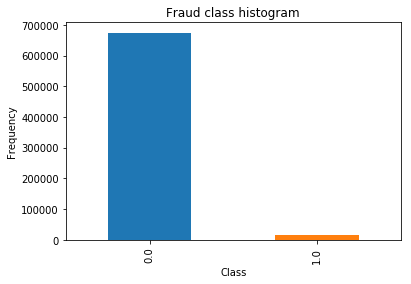

In [24]:
count_classes = pd.value_counts(fraudsters_trans['Fraudster'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

##### Sample of fraud customers/transactions is extremly small

In [43]:
# Print the shape of the data
data = fraudsters_trans.sample(frac=0.5, random_state = 1)
print(data.shape)
print(data.describe())

(344326, 16)
           CURRENCY        AMOUNT       STATE_x  MERCHANT_CATEGORY  \
count  3.443260e+05  3.443260e+05  3.443260e+05       3.443260e+05   
mean  -1.457524e+18  3.171983e+04 -5.308987e+18      -2.374184e+17   
std    3.336632e+18  2.588321e+06  4.767402e+18       3.519031e+18   
min   -9.075915e+18  0.000000e+00 -8.631833e+18      -9.018335e+18   
25%   -4.191206e+18  4.800000e+02 -7.079716e+18       0.000000e+00   
50%   -4.191206e+18  1.410000e+03 -7.079716e+18       0.000000e+00   
75%    4.925179e+17  5.000000e+03 -7.079716e+18       0.000000e+00   
max    8.677587e+18  9.000000e+08  7.623718e+18       8.786035e+18   

       MERCHANT_COUNTRY  ENTRY_METHOD       USER_ID          TYPE  \
count      3.443260e+05  3.443260e+05  3.443260e+05  3.443260e+05   
mean       3.203756e+17 -1.268080e+18 -2.652972e+17 -2.293341e+18   
std        3.700431e+18  6.349241e+18  5.347886e+18  3.780471e+18   
min       -9.207030e+18 -7.325538e+18 -9.212420e+18 -6.543723e+18   
25%       -

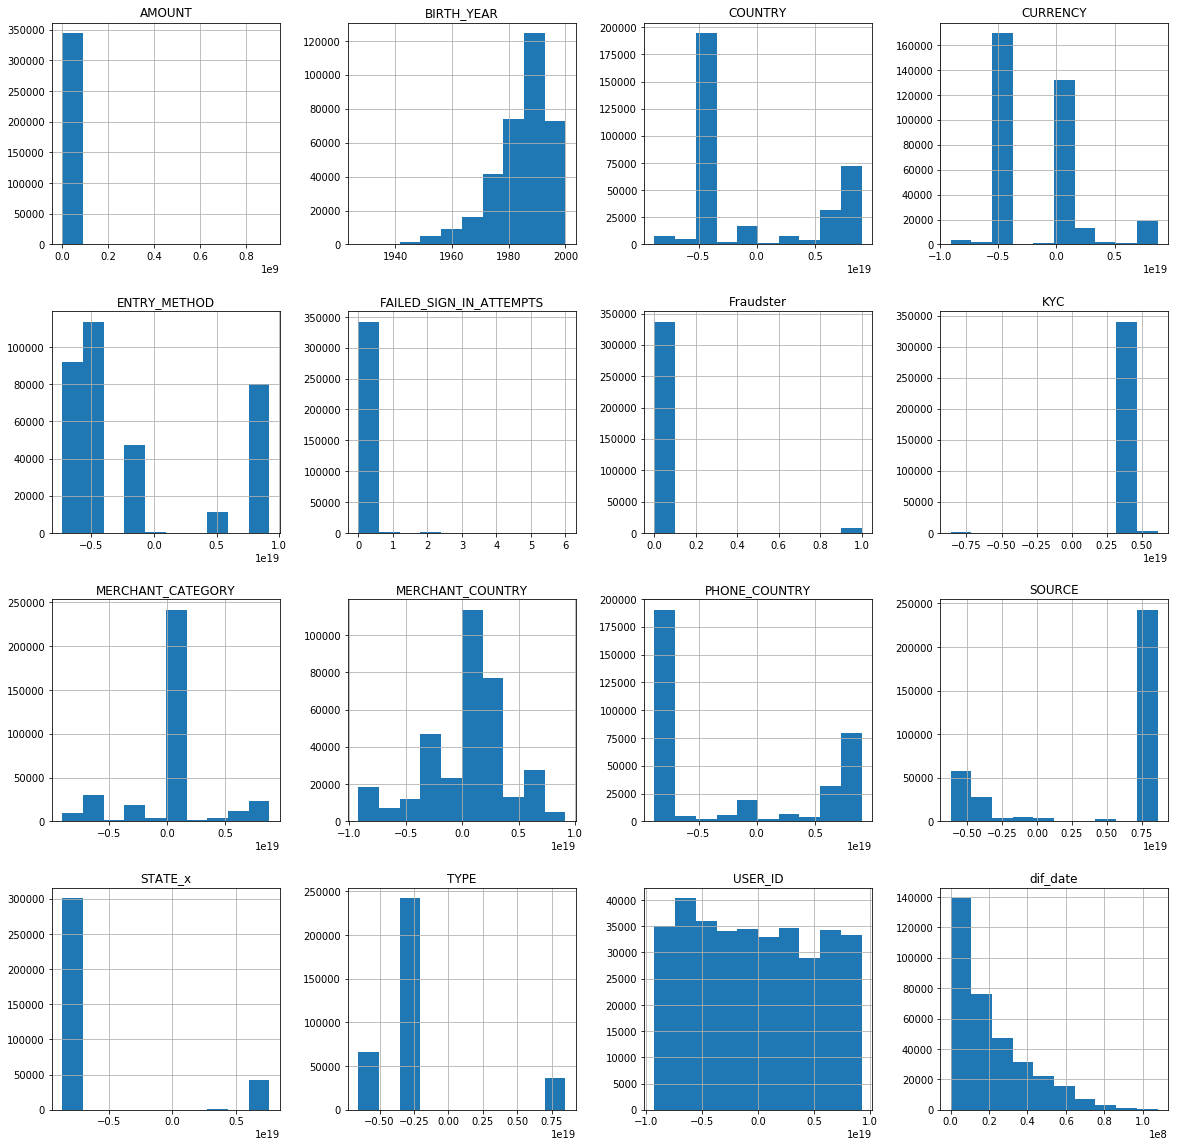

In [44]:
# Plot histograms of each parameter 
data.hist(figsize = (20, 20))
plt.show()

In [45]:
# Determine number of fraud cases in dataset

Fraud = fraudsters_trans[fraudsters_trans['Fraudster'] == 1]
Valid = data[data['Fraudster'] == 0]

outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(data[data['Fraudster'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Fraudster'] == 0])))

0.04314214093949777
Fraud Cases: 7231
Valid Transactions: 337095


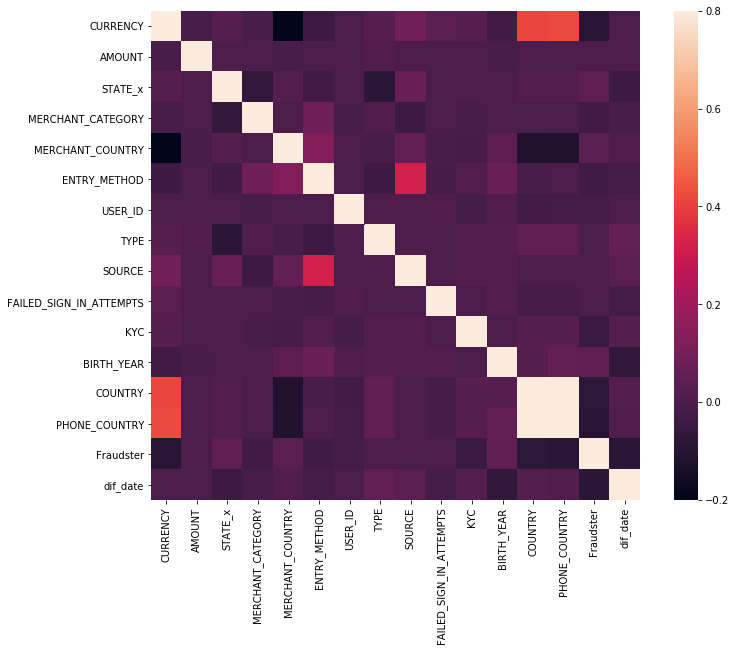

In [46]:
# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [47]:
# Get all the columns from the dataFrame
columns = data.columns.tolist()

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Fraudster", "HASHED_USER_ID"]]

# Store the variable we'll be predicting on
target = "Fraudster"

X = data[columns]
Y = data[target]

# Print shapes
print(X.shape)
print(Y.shape)

(344326, 15)
(344326,)


# Unsupervised Outlier Detection
Now that we have processed our data, we can begin deploying our machine learning algorithms. We will use the following techniques:

Local Outlier Factor (LOF)

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood.

Isolation Forest Algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [48]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# define random states
state = 1

# define outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlier_fraction,
                                        random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20,
        contamination=outlier_fraction)}

In [49]:
# Fit the model
plt.figure(figsize=(9, 7))
n_outliers = len(Fraud)


for i, (clf_name, clf) in tqdm(enumerate(classifiers.items())):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))

0it [00:00, ?it/s]/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation Forest: 21354
0.9379831903486812


1it [01:28, 88.47s/it]

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97    337095
         1.0       0.02      0.05      0.03      7231

   micro avg       0.94      0.94      0.94    344326
   macro avg       0.50      0.50      0.50    344326
weighted avg       0.96      0.94      0.95    344326

Local Outlier Factor: 21473
0.9376375876349738


2it [05:48, 140.05s/it]

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97    337095
         1.0       0.02      0.04      0.03      7231

   micro avg       0.94      0.94      0.94    344326
   macro avg       0.50      0.50      0.50    344326
weighted avg       0.96      0.94      0.95    344326



<Figure size 648x504 with 0 Axes>

Precision = 0.02. The rate of true positive in all positive cases.
Recall = 0.05. The rate of true positive in all true cases.
F1-score = 0.03
Model is not working with current dataset. 

###### As a trained model is working with so small accuracny I'll review account activity manualy using DataStudio. Full report can be found under this [Link](https://datastudio.google.com/open/1cv5JXuZliSNLDmqfMXP4A69-kvwtpl-_)

In [50]:
from IPython.core.display import display, HTML
display(HTML('<iframe width="1000" height="1360" src="https://datastudio.google.com/embed/reporting/1cv5JXuZliSNLDmqfMXP4A69-kvwtpl-_/page/omhk" frameborder="0" style="border:0" allowfullscreen></iframe>'))

## Possible fraud activity:

In [51]:
from IPython.core.display import display, HTML
display(HTML('<iframe width="1000" height="1360" src="https://datastudio.google.com/embed/reporting/1cv5JXuZliSNLDmqfMXP4A69-kvwtpl-_/page/DDik" frameborder="0" style="border:0" allowfullscreen></iframe>'))



# Task 3.a - Wide-open Analysis:

#### The MLRO is asking for some information about account activity for their annual report. Explore the transactional data. Provide a histogram showing the turnover per account (inbound funds + outbound funds only). Don’t forget to handle for different currencies! (10 points)

# Task 3.b - Wide-open Analysis:

#### Using the diagram above and your favorite analytical tool, tell us some statistical measures about it (e.g. mean, median, IQR, mode, distribution, local maximums, etc) and comment on its implications from a regulatory and best practice perspective. This analysis will be going to the board, so be clear and precise, including references to regulation and guidance. (25 points)



In [52]:
from IPython.core.display import display, HTML
display(HTML('<iframe width="1000" height="1360" src="https://datastudio.google.com/embed/reporting/1cv5JXuZliSNLDmqfMXP4A69-kvwtpl-_/page/3Bmf" frameborder="0" style="border:0" allowfullscreen></iframe>'))



# Task 4 - Hot Debate

#### There is a proposal for the Executive Risk Committee raised by the Onboarding team to streamline our politically exposed persons (PEP) process at client onboarding. Like any other company, Revolut must maintain a higher level of due diligence on PEPs. 

The proposal is straightforward. 

Once an alert from our favorite screening provider comes through, we will surface a series of prompts within the app to corroborate the match. If the answers show that the user is a PEP, they will be flagged as such. If not, the PEP flags will be cleared. The PEP status will feed into our risk assessment of the customer as they currently do - there is no planned change of the risk assessment layer. The app will ask a series of questions such as:
1. What is your occupation?
2. Have you or a family member ever held political office in the last 10 years?
3. Pick any of the following positions that you have held:
  1. Councillor, Brighton, UK, 2015-2018
  2. Councillor, Southwark Borough, London, UK 2013-2016
  3. Deputy Minister of Justice, UK, 2011
  4. Secretary to the UN, 2010
  5. None of the above

The screening team that is currently doing this process will be repurposed and retrained to helping conduct source of funds due diligence.

1. The executive risk committee has a fondness for flow diagrams. Use draw.io to draw out any system schematics and to show your understanding of the solution. Submit the .xml file by going to File > Save As > Device.
2. Analyse the risks involved and assess how they are mitigated by this proposal. What do you think of this proposal? Do you agree or disagree? 
3. What improvements would you make? How would these improvements change the system and affect the risks you’ve outlined in 2)?
4. What is your recommendation? 


In [53]:
from IPython.core.display import display, HTML
display(HTML('<iframe width="1000" height="1360" src="https://datastudio.google.com/embed/reporting/1cv5JXuZliSNLDmqfMXP4A69-kvwtpl-_/page/jhhk" frameborder="0" style="border:0" allowfullscreen></iframe>'))